In [1]:
import pandas as pd
import numpy as np
import shutil
from datetime import datetime
import multiprocessing

import tensorflow as tf
from tensorflow import data
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt

print(tf.__version__)


/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


In [2]:
MODEL_NAME = 'seq-model-01'

SEQUENCE_LENGTH = 20
INPUT_SEQUENCE_LENGTH = 16
OUTPUT_SEQUENCE_LENGTH = SEQUENCE_LENGTH - INPUT_SEQUENCE_LENGTH

TRAIN_DATA_SIZE = 1000 # sequences (entries)
TEST_DATA_SIZE = 100

TRAIN_DATA_FILE = 'data/seq01.train.csv'
TEST_DATA_FILE = 'data/seq01.test.csv'

RESUME_TRAINING = False
MULTI_THREADING = True

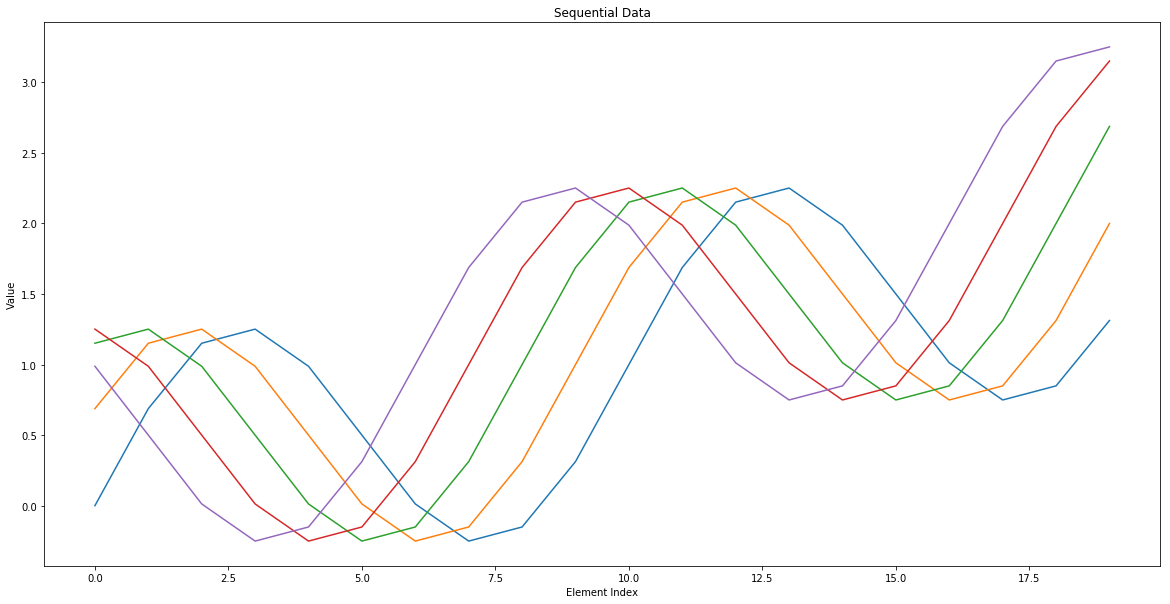

In [3]:
NOISE_RANGE = 0.0
TREND = 10.
OSCILIATION = 5.
np.random.seed = 19831006

def create_sequence(start_value):

    x =  np.array(range(start_value, start_value+SEQUENCE_LENGTH))
    noise = np.random.normal(0, NOISE_RANGE, SEQUENCE_LENGTH)
    y = np.sin(np.pi * x / OSCILIATION) + (x / TREND + noise)
    return y

plt.close('all')
plt.figure(figsize=(20, 10))

plt.subplot(1,1,1)
plt.title("Sequential Data")

for i in range(0, 5):
    
    x = range(SEQUENCE_LENGTH)
    y = create_sequence(i)
    plt.plot(x,y)

plt.xlabel("Element Index")
plt.ylabel("Value")
plt.show()

In [4]:


def to_csv(filename, N):
    with open(filename, 'w') as file_writer:
        for line_index in range(0, N):
            sequence = create_sequence(line_index)
            csv_line = ",".join(map(str, sequence))
            file_writer.write(csv_line + '\n')

to_csv(TRAIN_DATA_FILE, TRAIN_DATA_SIZE)  # 1000 sequences
to_csv(TEST_DATA_FILE,  TEST_DATA_SIZE)



In [5]:
pd.read_csv(TRAIN_DATA_FILE,header=None).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.687785,1.151057,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215
1,0.687785,1.151057,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000
2,1.151057,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000,2.687785
3,1.251057,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000,2.687785,3.151057
4,0.987785,0.500000,0.012215,-0.251057,-0.151057,0.312215,1.000000,1.687785,2.151057,2.251057,1.987785,1.500000,1.012215,0.748943,0.848943,1.312215,2.000000,2.687785,3.151057,3.251057


In [6]:
DEFAULTS = [[0.0] for i in range(0, SEQUENCE_LENGTH)]
VALUES_FEATURE_NAME = 'values'

In [7]:
def parse_csv_row(csv_row):
    
    # sequence is a list of tensors
    sequence = tf.decode_csv(tf.expand_dims(csv_row, -1), record_defaults=DEFAULTS)  
    
    input_sequence = sequence[ :INPUT_SEQUENCE_LENGTH]  # input elements in the sequence
    output_sequence = sequence[INPUT_SEQUENCE_LENGTH: ] # output elements in the sequence
    
    input_sequence_tensor = tf.concat(input_sequence, axis=1)
    output_sequence_tensor = tf.concat(output_sequence, axis=1)
    
    return {VALUES_FEATURE_NAME: input_sequence_tensor}, output_sequence_tensor

In [8]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=1, 
                 batch_size=20):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row), 
                          num_parallel_calls=num_threads)
    
    #dataset = dataset.batch(batch_size) #??? very long time
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()
    return features, target

In [9]:
features, target = csv_input_fn(files_name_pattern="")
print("Features in CSV: {}".format(features))
print("Target in CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 20
Epoch Count: 1
Mode: eval
Shuffle: False

Features in CSV: {'values': <tf.Tensor 'IteratorGetNext:0' shape=(?, 16) dtype=float32>}
Target in CSV: Tensor("IteratorGetNext:1", shape=(?, 4), dtype=float32)


In [10]:
def rnn_model_fn(features, labels, mode, params):
    
    # 0. Reformat input shape to become a sequence
    inputs = tf.split(features[VALUES_FEATURE_NAME], INPUT_SEQUENCE_LENGTH, 1)
    print('inputs={}'.format(inputs))
    
    # 1. configure the RNN
    lstm_cell = rnn.BasicLSTMCell(
        num_units=params.hidden_units, 
        forget_bias=params.forget_bias,
        activation=tf.nn.tanh
    )

    
    outputs, _ = rnn.static_rnn(cell=lstm_cell, 
                                inputs=inputs, 
                                dtype=tf.float32)
    
    # slice to keep only the last cell of the RNN
    outputs = outputs[-1]
    print('last outputs={}'.format(outputs))
    
    # output is result of linear activation of last layer of RNN
#     weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
#     bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
#     predictions = tf.matmul(outputs, weight) + bias
    
    predictions = tf.layers.dense(inputs=outputs,
                                  units=OUTPUT_SEQUENCE_LENGTH,
                                  activation=None)
    
    predict_output = {'values': predictions}
    
    if mode == tf.estimator.ModeKeys.PREDICT:

        export_outputs = {
                'predictions': tf.estimator.export.PredictOutput(predict_output)
            }

        return tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=predict_output,
                export_outputs=export_outputs)


    # Calculate loss using mean squared error
    loss = tf.losses.mean_squared_error(labels, predictions)

    # Create Optimiser
    optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate)

    # Create training operation
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # Calculate root mean squared error as additional eval metric
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(labels, predictions),
        "mae": tf.metrics.mean_absolute_error(labels, predictions)
    }

    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                                loss=loss,
                                                train_op=train_op,
                                                eval_metric_ops=eval_metric_ops)

    return estimator_spec


def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=rnn_model_fn, 
                                  params=hparams, 
                                  config=run_config)
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

In [11]:
NUM_EPOCHS = 10000
BATCH_SIZE = 100
EVAL_AFTER_SEC = 15
TOTAL_STEPS = (TRAIN_DATA_SIZE/BATCH_SIZE)*NUM_EPOCHS

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    hidden_units=20,
    forget_bias=1.0,
    learning_rate=0.01,
    max_steps = TOTAL_STEPS
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig(
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_DATA_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_DATA_SIZE/BATCH_SIZE)
print("Total Steps:", TOTAL_STEPS)
print("That is 1 evaluation step after each",EVAL_AFTER_SEC," training seconds")


[('batch_size', 100), ('forget_bias', 1.0), ('hidden_units', 20), ('learning_rate', 0.01), ('max_steps', 100000.0), ('num_epochs', 10000)]
Model Directory: trained_models/seq-model-01

Dataset Size: 1000
Batch Size: 100
Steps per Epoch: 10.0
Total Steps: 100000.0
That is 1 evaluation step after each 15  training seconds


In [12]:
def csv_serving_input_fn():
    
    SERVING_DEFAULTS =  [[0.0] for i in range(0, INPUT_SEQUENCE_LENGTH)]

    rows_string_tensor = tf.placeholder(dtype=tf.string,
                                         shape=[None],
                                         name='csv_rows')
    
    receiver_tensor = {'csv_rows': rows_string_tensor}

    row_columns = tf.expand_dims(rows_string_tensor, -1)
    columns = tf.decode_csv(row_columns, record_defaults=SERVING_DEFAULTS)
    input_sequence_tensor = tf.concat(columns, axis=1)
    features = {VALUES_FEATURE_NAME: input_sequence_tensor}

    return tf.estimator.export.ServingInputReceiver(
        features, receiver_tensor)

In [13]:
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILE,
        mode = tf.estimator.ModeKeys.TRAIN,
        num_epochs=hparams.num_epochs,
        batch_size=hparams.batch_size
    ),
    max_steps=hparams.max_steps,
    hooks=None
)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILE,
        mode=tf.estimator.ModeKeys.EVAL,
        num_epochs=1,
        batch_size=hparams.batch_size,
            
    ),
    exporters=[tf.estimator.LatestExporter(
        name="forecast",  # the name of the folder in which the model will be exported to under export
        serving_input_receiver_fn=csv_serving_input_fn,
        exports_to_keep=1,
        as_text=True)],
    #throttle_secs = EVAL_AFTER_SEC,
    steps=None
)


In [14]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 

    
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

estimator = create_estimator(run_config, hparams)

tf.estimator.train_and_evaluate(
    estimator=estimator,
    train_spec=train_spec, 
    eval_spec=eval_spec
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Removing previous artifacts...
Experiment started at 06:10:37
.......................................
INFO:tensorflow:Using config: {'_model_dir': 'trained_models/seq-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f526bb61c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_sec

KeyboardInterrupt: 

In [15]:
train_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TRAIN_DATA_SIZE)

test_input_fn = lambda: csv_input_fn(files_name_pattern= TEST_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TEST_DATA_SIZE)

estimator = create_estimator(run_config, hparams)

train_results = estimator.evaluate(input_fn=train_input_fn, steps=1)
train_rmse = str(train_results["rmse"])
print()
print("######################################################################################")
print("# Train RMSE: {} - {}".format(train_rmse, train_results))
print("######################################################################################")

test_results = estimator.evaluate(input_fn=test_input_fn, steps=1)
test_rmse = str(test_results["rmse"])
print()
print("######################################################################################")
print("# Test RMSE: {} - {}".format(test_rmse, test_results))
print("######################################################################################")

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/seq-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f526bb61c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>


* data input_fn:
Input file(s): data/seq01.train.csv
Batch size: 1000
Epoch Count: 1
Mode: eval
Shuffle: False

INFO:tensorflow:Calling model_fn.
inputs=[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1

In [16]:
import itertools

LEN = 500

predict_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILE, 
                                      mode= tf.estimator.ModeKeys.PREDICT,
                                      batch_size=TRAIN_DATA_SIZE)

predictions = list(itertools.islice(estimator.predict(input_fn=predict_input_fn),LEN))
prediction_outputs = list(map(lambda item: list(item["values"]),predictions[:3]))
print()
print("Predicted Values: {}".format(prediction_outputs))


* data input_fn:
Input file(s): data/seq01.train.csv
Batch size: 1000
Epoch Count: 1
Mode: infer
Shuffle: False

INFO:tensorflow:Calling model_fn.
inputs=[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:10' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:11' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:12' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:13' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:14' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:15' shape=(?, 1) dtype=float32>]
last outputs=Tensor("rnn/basic_lstm_ce

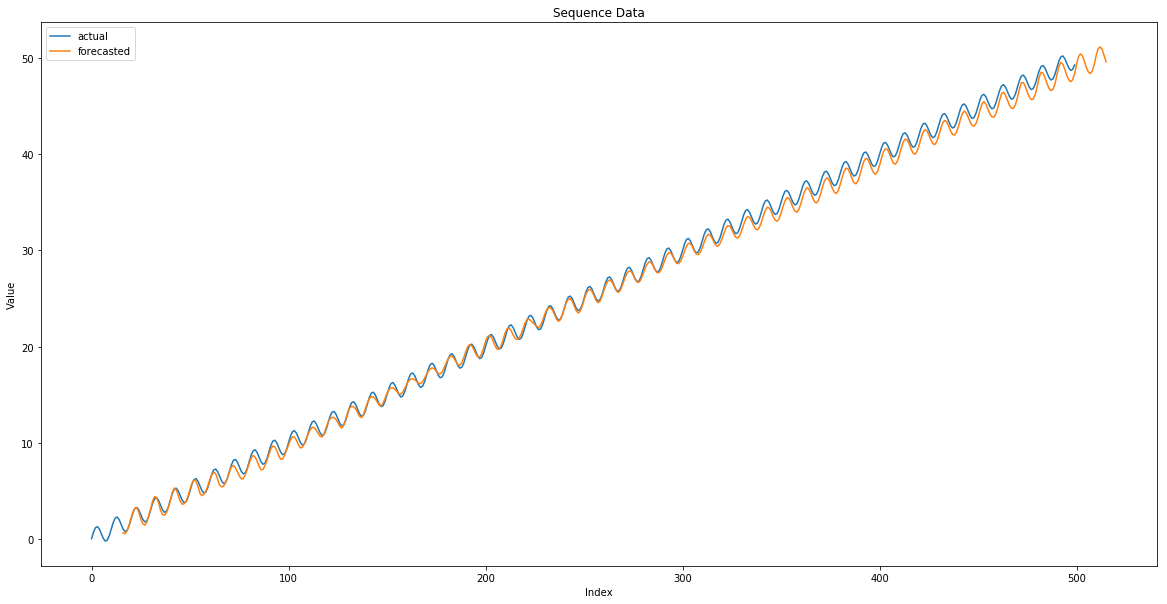

In [17]:
x =  np.array(range(0, LEN))
noise = np.random.normal(0, NOISE_RANGE, LEN)
actual_values = np.sin(np.pi * x / OSCILIATION) + (x / TREND + noise)
forecasted_values = list(map(lambda item: list(item["values"])[0],predictions))



plt.close('all')
plt.figure(figsize=(20, 10))
plt.title("Sequence Data")
plt.plot(x, actual_values, label='actual')
plt.plot(x+INPUT_SEQUENCE_LENGTH, forecasted_values, label='forecasted')
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()